## Prepare Data

In [ ]:
# First install package from terminal:
!pip install -U pip
!pip install -U setuptools wheel
!pip install autogluon  # autogluon==0.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/p

In [1]:
# import all required modules
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

pd.set_option('display.max_rows', None)  ###
pd.set_option('display.max_columns', None)  ###
pd.set_option('display.width', None)  ###
pd.set_option('display.max_colwidth', None)  ###

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import cohen_kappa_score
from sklearn.inspection import permutation_importance

In [2]:
# connect colab with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import dataset
file = '/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/df_mixed_discharge.csv'
raw_df = pd.read_csv(file, low_memory=False)

In [4]:
# examine the variables (names)
raw_df.columns

Index(['Unnamed: 0', 'HADM_ID', 'subject_id', 'ethnicity', 'admission_type',
       'admission_location', 'insurance', 'religion', 'marital_status',
       'icu_los', 'gender', 'age', 'urea_n_min', 'urea_n_max', 'urea_n_mean',
       'platelets_min', 'platelets_max', 'platelets_mean', 'magnesium_max',
       'albumin_min', 'calcium_min', 'resprate_min', 'resprate_max',
       'resprate_mean', 'glucose_min', 'glucose_max', 'glucose_mean', 'hr_min',
       'hr_max', 'hr_mean', 'sysbp_min', 'sysbp_max', 'sysbp_mean',
       'diasbp_min', 'diasbp_max', 'diasbp_mean', 'temp_min', 'temp_max',
       'temp_mean', 'sapsii', 'sofa', 'urine_min', 'urine_mean', 'urine_max',
       'patientweight', 'readmit_dt', 'age_cat', 'type_stay', 'prev_adm',
       'emergency_dpt', 'icd_chapter', 'origin_patient', 'los',
       'dest_discharge', 'discharge'],
      dtype='object')

In [ ]:
# drop the variables to be exempted from the analysis and rename new dataset
df = raw_df.drop(columns = ['Unnamed: 0', 'HADM_ID', 'subject_id','icu_los'])


39841 39841


In [ ]:
# selection criterion : only patients 18 and older and with a length of stay or 1 day or greater
df = df.loc[(df['age']>=18) & (df['los']>=1),:]
# compare size of dataframe before and after selection
len(raw_df), len(df)

(39841, 39105)

In [ ]:
# check proportion of missing values
missing = pd.DataFrame(df.isna().mean(), columns = ['proportions'])
missing.sort_values('proportions',ascending = False)

,proportions
patientweight,0.515177
albumin_min,0.313771
type_stay,0.251477
calcium_min,0.024728
glucose_min,0.002966
glucose_mean,0.002966
glucose_max,0.002966
magnesium_max,0.002839
temp_mean,0.001585
temp_max,0.001585


In [ ]:
# drop variables having more than 20 % missing values
df = df.drop(columns=['albumin_min','patientweight','type_stay'])

In [ ]:
# save df
df_copy = df.copy()

In [ ]:
# impute missing values
df = df_copy.interpolate()
df.isna().mean()

ethnicity             0.0
admission_type        0.0
admission_location    0.0
insurance             0.0
religion              0.0
marital_status        0.0
gender                0.0
age                   0.0
urea_n_min            0.0
urea_n_max            0.0
urea_n_mean           0.0
platelets_min         0.0
platelets_max         0.0
platelets_mean        0.0
magnesium_max         0.0
calcium_min           0.0
resprate_min          0.0
resprate_max          0.0
resprate_mean         0.0
glucose_min           0.0
glucose_max           0.0
glucose_mean          0.0
hr_min                0.0
hr_max                0.0
hr_mean               0.0
sysbp_min             0.0
sysbp_max             0.0
sysbp_mean            0.0
diasbp_min            0.0
diasbp_max            0.0
diasbp_mean           0.0
temp_min              0.0
temp_max              0.0
temp_mean             0.0
sapsii                0.0
sofa                  0.0
urine_min             0.0
urine_mean            0.0
urine_max   

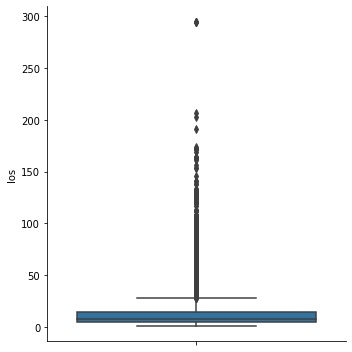

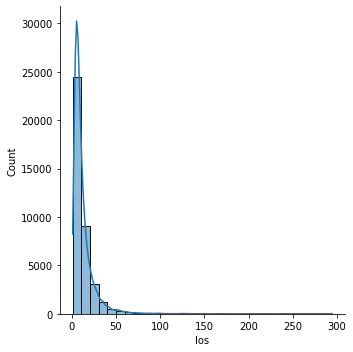

In [ ]:
# check distribution of outcome
sns.catplot(kind='box', data=df, y='los');
sns.displot(data=df, x="los", bins=30, kde=True) ;

In [ ]:
# compute Lower and Upper Fence according to Tukey's criteria
y = df['los']
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3-Q1
LF = Q1 - 1.5*IQR
UF = Q3 + 1.5*IQR
print(f'First quartile = {Q1:.3f}, Third Quartile = {Q3:.3f}, Interquartile Interval = {IQR:.3f}')
print(f'Lower Fence = {LF:.3f}, Upper Fence = {UF:.3f}')

First quartile = 5.142, Third Quartile = 14.506, Interquartile Interval = 9.365
Lower Fence = -8.905, Upper Fence = 28.553


In [ ]:
# create categorical LOS variable where prolonged LOS is any value greater than Upper Fence
df['los_cat'] = df['los']> UF
df = df.drop(columns=['los', 'discharge'])

In [ ]:
# split the data into training and test
df_train, df_test = train_test_split(df, train_size=0.80, stratify = df['los_cat'], random_state=42)

## Train the Tabular Model (Structured DataSet)

In [ ]:
# paramètres du modèle
save_path = '/content/drive/MyDrive/AutoGluon/models/tabular_2022-05-29'
label = 'los_cat'
metric = 'roc_auc'

In [ ]:
# run the tabular predictor ensemble of models
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label=label, eval_metric=metric,path=save_path)
predictor.fit(df_train)

Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/MyDrive/AutoGluon/models/tabular_2022-05-29/"
AutoGluon Version:  0.4.1
Python Version:     3.7.13
Operating System:   Linux
Train Data Rows:    31284
Train Data Columns: 46
Label Column: los_cat
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [False, True]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = True, class 0 = False
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    50850.8 MB
	Train Data (Original)  Memory Usage: 35.0 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_met

[1000]	valid_set's binary_logloss: 0.107246


	0.9688	 = Validation score   (roc_auc)
	8.16s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: LightGBM ...
	0.9662	 = Validation score   (roc_auc)
	3.53s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9575	 = Validation score   (roc_auc)
	4.88s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9606	 = Validation score   (roc_auc)
	4.97s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: CatBoost ...
	0.968	 = Validation score   (roc_auc)
	64.05s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9571	 = Validation score   (roc_auc)
	1.89s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9598	 = Validation score   (roc_auc)
	1.66s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.9513	 = Validation score   (roc_auc)
	33.07s	 = Training   runtime
	0.06s	 = Val

In [ ]:
# evaluate performance on the test set
per_tab = predictor.evaluate(df_test)
per_tab

Evaluation: roc_auc on test data: 0.9641636629387687
Evaluations on test data:
{
    "roc_auc": 0.9641636629387687,
    "accuracy": 0.961513872906278,
    "balanced_accuracy": 0.7832808541363149,
    "mcc": 0.6856164650946518,
    "f1": 0.6893704850361198,
    "precision": 0.8630490956072352,
    "recall": 0.5738831615120275
}


{'accuracy': 0.961513872906278,
 'balanced_accuracy': 0.7832808541363149,
 'f1': 0.6893704850361198,
 'mcc': 0.6856164650946518,
 'precision': 0.8630490956072352,
 'recall': 0.5738831615120275,
 'roc_auc': 0.9641636629387687}

In [ ]:
# save the class and probability predictions
y_pred = predictor.predict(df_test)
y_pred_proba = predictor.predict_proba(df_test).iloc[:,1]

In [ ]:
# compute other metrics
def perf(y_test, y_pred, y_pred_proba):
  kappa = cohen_kappa_score(y_test, y_pred)
  precision, recall, prc_th = precision_recall_curve(y_test, y_pred_proba)
  prc_auc = auc(recall, precision)
  return kappa, prc_auc

perf = perf(df_test['los_cat'], y_pred, y_pred_proba)
perf_dict = {"Cohen's Kappa": perf[0], "PRC AUC": perf[1]}
perf_dict

{"Cohen's Kappa": 0.6697398640672013, 'PRC AUC': 0.7889881703182428}

In [ ]:
# compare the different models
leaderboard = predictor.leaderboard(df_test)
leaderboard

                  model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2    0.964164   0.971754        3.181579       0.471285  154.759028                 0.009968                0.001828           2.277895            2       True         14
1              CatBoost    0.962988   0.968009        0.036627       0.019790   64.046508                 0.036627                0.019790          64.046508            1       True          7
2              LightGBM    0.962629   0.966169        0.066206       0.023300    3.527764                 0.066206                0.023300           3.527764            1       True          4
3            LightGBMXT    0.962444   0.968811        0.169144       0.053024    8.161331                 0.169144                0.053024           8.161331            1       True          3
4               XGBoost    0.962104

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.964164,0.971754,3.181579,0.471285,154.759028,0.009968,0.001828,2.277895,2,True,14
1,CatBoost,0.962988,0.968009,0.036627,0.019790,64.046508,0.036627,0.019790,64.046508,1,True,7
2,LightGBM,0.962629,0.966169,0.066206,0.023300,3.527764,0.066206,0.023300,3.527764,1,True,4
3,LightGBMXT,0.962444,0.968811,0.169144,0.053024,8.161331,0.169144,0.053024,8.161331,1,True,3
4,XGBoost,0.962104,0.966480,2.165633,0.024083,2.886953,2.165633,0.024083,2.886953,1,True,11
5,LightGBMLarge,0.962050,0.967479,0.060662,0.019098,4.489539,0.060662,0.019098,4.489539,1,True,13
6,RandomForestEntr,0.951763,0.960558,0.289938,0.210362,4.972241,0.289938,0.210362,4.972241,1,True,6
7,ExtraTreesEntr,0.949789,0.959831,0.372962,0.210125,1.656925,0.372962,0.210125,1.656925,1,True,9
8,ExtraTreesGini,0.947647,0.957087,0.352236,0.210206,1.889423,0.352236,0.210206,1.889423,1,True,8
9,NeuralNetTorch,0.947009,0.950061,0.200113,0.080182,38.171714,0.200113,0.080182,38.171714,1,True,12


In [ ]:
# compute feature importance
importance = predictor.feature_importance(df_test)
importance

These features in provided data are not utilized by the predictor and will be ignored: ['readmit_dt']
Computing feature importance via permutation shuffling for 45 features using 5000 rows with 5 shuffle sets...
	198.69s	= Expected runtime (39.74s per shuffle set)
	100.51s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
urea_n_max,0.036923,0.003381,0.000008,5,0.043885,0.029960
platelets_min,0.035196,0.002762,0.000005,5,0.040883,0.029509
urea_n_min,0.012251,0.002926,0.000362,5,0.018276,0.006227
platelets_max,0.011368,0.002509,0.000267,5,0.016533,0.006203
platelets_mean,0.005688,0.002148,0.002038,5,0.010110,0.001265
temp_max,0.002552,0.000252,0.000011,5,0.003070,0.002034
resprate_max,0.002369,0.000724,0.000929,5,0.003859,0.000878
icd_chapter,0.002089,0.000297,0.000048,5,0.002701,0.001478
magnesium_max,0.002040,0.001025,0.005624,5,0.004150,-0.000071
calcium_min,0.001742,0.000810,0.004290,5,0.003410,0.000075


In [ ]:
# feature importance in percentage
importance['percent'] = 100*importance['importance']/importance['importance'].max()
importance

,importance,stddev,p_value,n,p99_high,p99_low,percent
urea_n_max,0.036923,0.003381,0.000008,5,0.043885,0.029960,100.000000
platelets_min,0.035196,0.002762,0.000005,5,0.040883,0.029509,95.324319
urea_n_min,0.012251,0.002926,0.000362,5,0.018276,0.006227,33.181544
platelets_max,0.011368,0.002509,0.000267,5,0.016533,0.006203,30.789522
platelets_mean,0.005688,0.002148,0.002038,5,0.010110,0.001265,15.404172
temp_max,0.002552,0.000252,0.000011,5,0.003070,0.002034,6.911350
resprate_max,0.002369,0.000724,0.000929,5,0.003859,0.000878,6.414911
icd_chapter,0.002089,0.000297,0.000048,5,0.002701,0.001478,5.658836
magnesium_max,0.002040,0.001025,0.005624,5,0.004150,-0.000071,5.524481
calcium_min,0.001742,0.000810,0.004290,5,0.003410,0.000075,4.718881


In [ ]:
# path to save all the results
path_results = '/content/drive/MyDrive/AutoGluon/results/tabular_2022-05-29'

In [ ]:
perf_dict.update(per_tab)

In [ ]:
# save performances
df_perf = pd.DataFrame.from_dict(perf_dict, orient='index', columns=['performances'])
df_perf.to_excel(path_results+'/df_perf.xlsx')

In [ ]:
# save leaderboard
leaderboard.to_excel(path_results+'/leaderboard.xlsx')

In [ ]:
# save importance
importance.to_excel(path_results+'/importance.xlsx')